## Exploratory Data Analysis (EDA)

### Analisis Inicial

En esta sección, vamos a explorar la información básica de nuestro conjunto de datos para tener una visión general de su estructura y características. Comenzaremos cargando el archivo y verificando algunas estadísticas clave, como las primeras filas, el tipo de datos y los valores únicos de algunas columnas relevantes.

In [2]:
import pandas as pd

df = pd.read_csv("data/vertical_raw_data.csv", sep=";")

import warnings
warnings.filterwarnings("ignore")

C:\Users\tipir\AppData\Local\Temp\ipykernel_22260\414296975.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/vertical_raw_data.csv", sep=";")


In [3]:
print(df.head())
print(df.info())
print(df.describe())
print(f"Las clases unicas de: {df["metodoObtencion"].unique()}")
print(f"Las clases unicas de: {df["energiaVertida_kWh"].unique()}")


           cups       fecha   hora consumo_kWh metodoObtencion  \
0  0114f2a9ef8e  2021/08/11  01:00       0,449             NaN   
1  0114f2a9ef8e  2021/08/11  02:00       0,423             NaN   
2  0114f2a9ef8e  2021/08/11  03:00       0,411             NaN   
3  0114f2a9ef8e  2021/08/11  04:00       0,282             NaN   
4  0114f2a9ef8e  2021/08/11  05:00       0,255             NaN   

  energiaVertida_kWh  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100969 entries, 0 to 2100968
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   cups                object
 1   fecha               object
 2   hora                object
 3   consumo_kWh         object
 4   metodoObtencion     object
 5   energiaVertida_kWh  object
dtypes: object(6)
memory usage: 96.2+ MB
None
                cups       fecha     hora consumo_k

### Limpieza y preprocesamiento de datos

Una vez que hemos explorado el dataset, procederemos a realizar algunas tareas de limpieza. Primero, eliminaremos  la columna metodoObtencion y la columna energiaVertida_kWh, ya que no será relevante para el análisis de la serie temporal

In [4]:
df.drop(columns=['metodoObtencion'], inplace=True)
df.drop(columns=['energiaVertida_kWh'], inplace=True)
print(df.head())

           cups       fecha   hora consumo_kWh
0  0114f2a9ef8e  2021/08/11  01:00       0,449
1  0114f2a9ef8e  2021/08/11  02:00       0,423
2  0114f2a9ef8e  2021/08/11  03:00       0,411
3  0114f2a9ef8e  2021/08/11  04:00       0,282
4  0114f2a9ef8e  2021/08/11  05:00       0,255


Voy a preprocesar todas las columnas que quiero del dataset para que todas sigan un formato específico. Convertiré las columnas de fecha a a otra string pero con el mismo formato (formato dd/mm/yyyy). Transformare las columans de consumo_KWh y hora a float e int respectivamente para facilitar el trabajo con los datos.

In [5]:
def formatear_hora(hora):
    hora = str(hora).strip()
    
    # Convertir '1:00' a '01:00', etc.
    if len(hora.split(':')[0]) == 1:
        hora = '0' + hora
    
    # Eliminar '24:00:00' y '24:00' a '00:00' (formato más internacional)
    if hora == '24:00:00' or hora == '24:00':
        hora = '00:00'
    
    return hora

def limpiar_consumo(consumo):
    try:
        consumo = str(consumo).replace(',', '.')
        return float(consumo)
    except ValueError:
        print("HUBO ERROR")
        return float('nan')



df['fecha'] = pd.to_datetime(df['fecha'], format='mixed', dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df['consumo_kWh'] = df['consumo_kWh'].apply(limpiar_consumo)
df['hora'] = df['hora'].apply(formatear_hora)
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M', errors='coerce').dt.hour

print(df.dtypes)
print(df.head())


cups                   object
fecha          datetime64[ns]
hora                    int32
consumo_kWh           float64
dtype: object
           cups      fecha  hora  consumo_kWh
0  0114f2a9ef8e 2021-08-11     1        0.449
1  0114f2a9ef8e 2021-08-11     2        0.423
2  0114f2a9ef8e 2021-08-11     3        0.411
3  0114f2a9ef8e 2021-08-11     4        0.282
4  0114f2a9ef8e 2021-08-11     5        0.255


In [ ]:
nan_check = df.isna().sum()

print("Número de valores NaN en cada columna:")
print(nan_check)
df.to_csv('data/vertical_preprocessed_data.csv', sep=';', index=False)

Número de valores NaN en cada columna:
cups           0
fecha          0
hora           0
consumo_kWh    0
dtype: int64


## Transformación de datos

​Para analizar y agrupar datos de consumo eléctrico por vivienda y momento específico, es esencial transformar el conjunto de datos de un formato largo a un formato ancho. En el formato largo, cada fila representa una medición individual con columnas como 'cups', 'fecha', 'hora' y 'consumo_kWh'. Al pivotar estos datos al formato ancho, cada fila corresponderá a una vivienda única ('cups'), y las columnas representarán combinaciones específicas de fecha y hora, mostrando el consumo en cada celda. Este formato facilita la aplicación de algoritmos de clustering y análisis comparativos entre diferentes viviendas en momentos determinados.

In [ ]:
# No hecho, se hará en cada cuaderno que lo necesite
#df.to_csv('flat_preprocessed_data.csv', sep=';', index=False)

### Visualización de las distribuciones de consumo eléctrico

A continuación, realizaremos un análisis de la serie temporal para viviendas al azar. Esto nos permitirá observar cómo se distribuye el consumo eléctrico a lo largo del tiempo y detectar posibles patrones, tendencias o picos en su comportamiento. Utilizaremos Matplotlib para visualizar los datos y obtener una mejor comprensión de la evolución del consumo eléctrico de la vivienda.


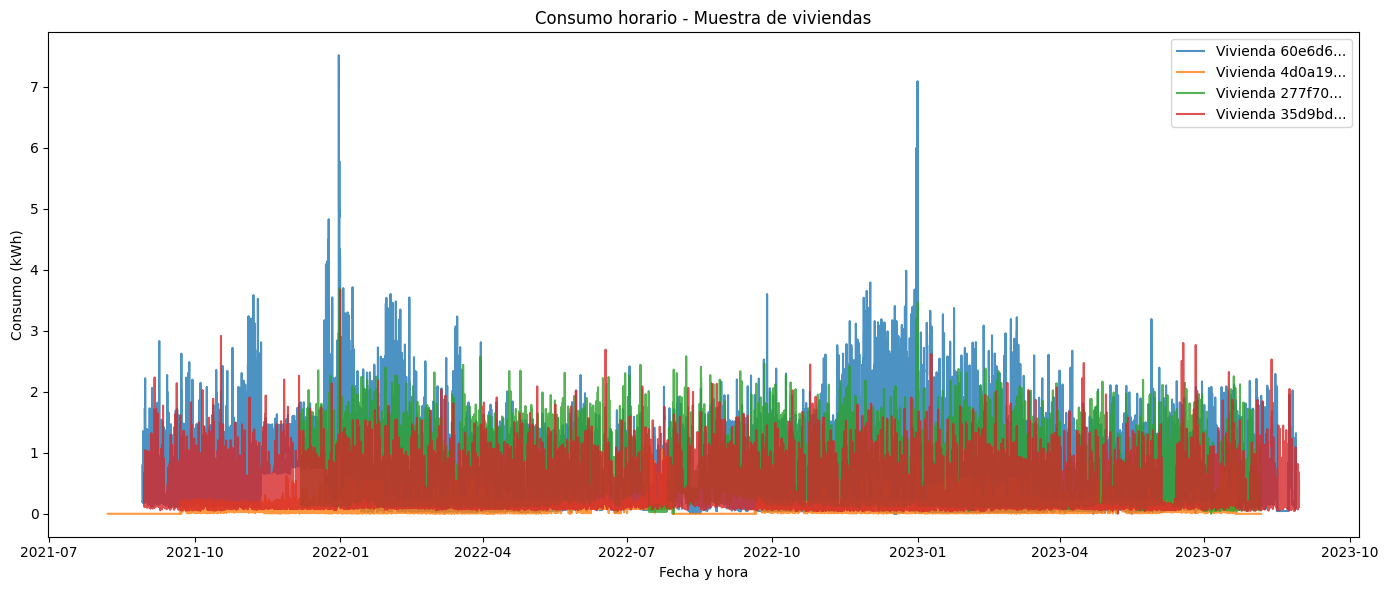

In [8]:
import matplotlib.pyplot as plt

viviendas_sample = df['cups'].drop_duplicates().sample(4, random_state=42)

plt.figure(figsize=(14, 6))

for i, vivienda in enumerate(viviendas_sample):
    df_viv = df[df['cups'] == vivienda].sort_values(by=['fecha', 'hora'])
    fechas = df_viv['fecha'] + pd.to_timedelta(df_viv['hora'], unit='h')
    plt.plot(fechas, df_viv['consumo_kWh'], label=f'Vivienda {vivienda[:6]}...', alpha=0.8)

plt.title("Consumo horario - Muestra de viviendas")
plt.xlabel("Fecha y hora")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.tight_layout()
plt.show()



### MAYBE

Si tienes varias viviendas (diferentes CUPS), puede ser útil realizar un análisis de agrupamiento por vivienda para ver si hay patrones de consumo comunes entre viviendas similares. Esto te ayudará más adelante en el proceso de clustering.

Puedes analizar si existen patrones estacionales o de consumo diario.